# New Approach

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Gamma

import bayesfunc as bf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from ipywidgets import interact_manual, interact, FloatSlider, IntSlider

dtype=t.float64
device="cpu"
#device="cuda"

# Toy Data

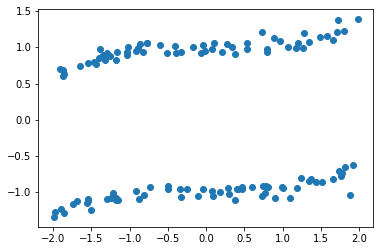

In [2]:
in_features = 1
out_features = 1
train_batch = 40
batches = 3
data_size = batches * train_batch

t.manual_seed(0)

def generate_data():
    noise = Gamma(2, 0.1)
    X = t.rand(data_size, in_features) * 4 - 2
    x_1 = X[:int(data_size/2), :]
    x_2 = X[int(data_size/2):, :]
    
    y = t.cat((
        x_1**3 + 20 + 0.1 * noise.sample((int(data_size/2), in_features)),
        x_2**3 - 20 - 0.1 * noise.sample((int(data_size/2), in_features))
    ))
    
    scale = y.std()
    y = y/scale
    
    xys = t.cat((X,y),1)
    xys = xys[t.randperm(xys.size()[0])]
    X = xys[:,0].unsqueeze(1).to(device=device, dtype=dtype)
    y = xys[:,1].unsqueeze(1).to(device=device, dtype=dtype)
    return X, y, scale

X, y, scale = generate_data()

plt.scatter(X.detach().cpu(), y.detach().cpu())

We model the probability of the outcome variable $y$ as
$$
P(y) = \frac{1}{Z}\prod^N_{i=1}P_i(y),
$$
writing the corresponding log-probability as
$$
\mathcal{L}(y) = \sum^N_{i=1}\mathcal{L}_i(y) - \log Z
$$
where each $L_i(y)$ is of the form:
$$
\mathcal{L}(y) = \sum^N_{i=1} - (y-f_i)\left(\alpha_i \Theta(y-f_i) - \beta_i\Theta(y-f_i)\right) - \log Z,
$$
where $\Theta(u)$ is Heaviside step with value $1$ if $u>0$ and $0$ otherwise, $\alpha_i > 0$ and $\beta_i > 0$ for all $i \in [1, N]$ and we also assume $f_i$ are ordered; that is, $f_i \le f_{i+1}$ for all $i \in [1,N]$. Crucially each of these terms in the summand is negative for all values of $y$, hence the probability is a valid member of the exponential family of distributions.

The normalising term $Z$ is found as
$$
Z = \frac{1}{a_0}e^{a_0f_1+b_0} + \sum^{N-1}_{j=1}\frac{1}{a_j}e^{b_j}\left(e^{a_jf_{j+1}}-e^{a_jf_j}\right) - \frac{1}{a_N}e^{a_Nf_N + b_N},
$$
where
\begin{align*}
a_j &= \sum^N_{i=j+1}\beta_i - \sum^j_{i=1}\alpha_i \\
b_j &= \sum^j_{i=1}\alpha_if_i - \sum^N_{i=j+1}\beta_if_i,
\end{align*}
In particular, we have the following edge cases which can be written explicitly; for $j=0$:
$$
a_0 = \sum^N_{i=1}\beta_i,\ \ \ \ b_0 = -\sum^N_{i=1}\beta_if_i
$$
and for $j=N$:
$$
a_N = -\sum^N_{i=1}\alpha_i,\ \ \ \ b_N = \sum^N_{i=1}\alpha_if_i.
$$

To enforce the constraints on the values of $\mathbf{f}$, $\mathbf{\alpha}$ and $\mathbf{\beta}$, we first ensure that each are positive. Let the $\mathbf{f}$ values returned from the network be denoted $\hat{f}$. The ordering constraint on $f$ is enforced by additionally outputting a base value $r$ to which $\hat{f}_1$ is added, giving $f_1 = r + \hat{f}_1$. Subsequent $f_i$ for $i > 1$ can be recovered by finding the cumulative sum $f_i = f_{i-1} + \hat{f}_i$.

We can devise a simple dynamic programming algorithm to compute these normalising terms $a_j$ and $b_j$ efficiently by computing vectors of their partial sums in $O(n)$ time.

In [3]:
inducing_batch = 40

# number of fs, alphas and betas
N = 10

# Select Data
data_X = X
data_y = y
scale = scale

class NET(nn.Module):
    """Yet unnamed, newfangled neural network thing"""
    def __init__(self, inducing_batch, N):
        hidden = 50
        super(NET, self).__init__()
        inducing_data = t.linspace(data_X.min(), data_X.max(), inducing_batch).unsqueeze(1)
        self.ia = bf.InducingAdd(inducing_batch=inducing_batch, inducing_data=inducing_data)
        self.ir = bf.InducingRemove(inducing_batch=inducing_batch)
        
        self.fc1 = bf.GILinear(in_features=1, out_features=hidden, inducing_batch=inducing_batch, bias=True)
        self.offset = bf.GILinear(in_features=hidden, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True)
        self.f = bf.GILinear(in_features=hidden, out_features=N, inducing_batch=inducing_batch, bias=True, full_prec=True)
        self.alpha = bf.GILinear(in_features=hidden, out_features=N, inducing_batch=inducing_batch, bias=True, full_prec=True)
        self.beta = bf.GILinear(in_features=hidden, out_features=N, inducing_batch=inducing_batch, bias=True, full_prec=True)
        
    def forward(self, x):
        x = self.ia(x)
        x = F.relu(self.fc1(x))
        # this can be positive or negative
        offset = self.ir(self.offset(x))
        # the following _must_ be non-negative, here we use softplus
        f = self.ir(F.softplus(self.f(x)))
        alpha = self.ir(F.softplus(self.alpha(x)))
        beta = self.ir(F.softplus(self.beta(x)))
        return offset, f, alpha, beta
    
net = NET(inducing_batch, N).to(device=device, dtype=dtype)

samples = 10
opt = t.optim.Adam(net.parameters(), lr=0.05)
for i in tqdm(range(500)):
    for batch in range(batches):
        l = batch * train_batch
        u = l     + train_batch
        batch_X = data_X[l:u].expand(samples, -1, -1)
        batch_y = data_y[l:u].expand(samples, -1, -1)
        opt.zero_grad()

        (offset, f, alpha, beta), logpq, _ = bf.propagate(net, batch_X)
        
        # Add an offset to f_0 for all samples, and all points in the batch
        offset = t.cat((
            offset,
            t.zeros_like(offset).expand(-1, -1, N-1).to(dtype=dtype, device=device)
        ),2)
        f = f + offset
        # Find the cumulative sum to ensure f_i <= f_{i+1}
        f = f.cumsum(2)
        
        # Log-likelihood terms
        res = batch_y - f
        ll_terms = -(res) * t.where(res > 0, alpha, -beta)
        
        # Calculating the normalising term ------------------------------------
        
        # Flip these matrices along third dimension by copying memory; O(n)
        b_flip = beta.flip(2)
        f_flip = f.flip(2)
        
        # Calculate vectors of partial sums ('_ps') in O(n) time
        a_ps = alpha.cumsum(2)
        b_ps = b_flip.cumsum(2).flip(2)
        af_ps = (alpha*f).cumsum(2)
        bf_ps = (b_flip * f_flip).cumsum(2).flip(2)

        # Calculate main coefficient vectors
        a_vec  = b_ps[:,:,1:] - a_ps[:,:,:-1]
        b_vec  = af_ps[:,:,:-1] - bf_ps[:,:,1:]
        
        # Calculate terms for interval y \in (-\infty, f_1]
        a_0 = b_ps[:,:,0]
        b_0 = - bf_ps[:,:,0]
        a_N = - a_ps[:,:,-1]
        b_N = af_ps[:,:,-1]
        
        # Calculate the normalising term
        Z = 1/a_0 * t.exp(a_0 * f[:,:,0] + b_0)
        Z = Z + (1/a_vec * t.exp(b_vec)*(t.exp(a_vec * f[:,:,1:])-t.exp(a_vec*f[:,:,:-1]))).sum(2)
        Z = Z - (1/a_N * t.exp(a_N * f[:,:,N-1] + b_N))
                        
        lls = ll_terms.sum(-1) - t.log(Z)
        ll = lls.mean(-1)
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        elbo = ll + logpq/data_size
        
        (-elbo.mean()).backward()
        opt.step()
        

In [4]:
num_pts = 100

def plot_density(x_loc):
    # The number of points to plot the quantile function at (ys)
    with t.no_grad():
        samples = 100
        xs = t.tensor([x_loc]).unsqueeze(1).to(dtype=dtype, device=device)
        ys = t.linspace(-5, 5, num_pts).unsqueeze(1).to(dtype=dtype, device=device)
        xs = xs.expand(samples, -1, -1)
        ys = ys.expand(samples, -1, -1)
        (ref, f, alpha, beta), _, _ = bf.propagate(net, xs)
        
        offset = t.cat((
            ref,
            t.zeros_like(ref).expand(-1, -1, N-1).to(dtype=dtype, device=device)
        ),2)
        f = f + offset
        # Find the cumulative sum to ensure f_i <= f_{i+1}
        f = f.cumsum(2)
        
        # Log-likelihood terms
        res = ys - f
        # TODO exponentiate here
        ll_terms = -(res) * t.where(res > 0, alpha, -beta)
        
        # Calculating the normalising term ------------------------------------
        
        # Flip these matrices along third dimension by copying memory; O(n)
        b_flip = beta.flip(2)
        f_flip = f.flip(2)
        
        # Calculate vectors of partial sums O(n)
        a_ps = alpha.cumsum(2)
        b_ps = b_flip.cumsum(2).flip(2)
        af_ps = (alpha*f).cumsum(2)
        bf_ps = (b_flip * f_flip).cumsum(2).flip(2)

        # Calculate main coefficient vectors
        a_vec  = b_ps[:,:,1:] - a_ps[:,:,:-1]
        b_vec  = af_ps[:,:,:-1] - bf_ps[:,:,1:]
        
        # Calculate terms for interval y \in (-\infty, f_1]
        a_0 = b_ps[:,:,0]
        b_0 = - bf_ps[:,:,0]
        a_N = - a_ps[:,:,-1]
        b_N = af_ps[:,:,-1]
        
        # Calculate the normalising term
        Z = 1/a_0 * t.exp(a_0 * f[:,:,0] + b_0)
        Z = Z + (1/a_vec * t.exp(b_vec)*(t.exp(a_vec * f[:,:,1:])-t.exp(a_vec*f[:,:,:-1]))).sum(2)
        Z = Z - (1/a_N * t.exp(a_N * f[:,:,N-1] + b_N))
                        
        ls = t.exp(ll_terms.sum(-1) - t.log(Z))
        l = ls.mean(0).detach().cpu()
        std = ls.std(0).detach().cpu()
        
        plt.plot(ys[0].detach().cpu(), l)
        plt.fill_between(ys[0].detach().cpu().squeeze(), (l+2*std).squeeze(), (l-2*std).squeeze(), alpha=0.2)
        plt.title(f"Distribution at x={x_loc}")
        plt.ylabel("Density")
        plt.xlabel("Y value")

interact(plot_density, x_loc=FloatSlider(min=data_X.min(), max=data_X.max()))

interactive(children=(FloatSlider(value=0.0, description='x_loc', max=1.9882662296295166, min=-1.9950559139251…

<function __main__.plot_density(x_loc)>